### Note: 
using 4 sample real data from PCSWMM outputs 

In [1]:
from Dataset_Class2 import Pluvial_Dataset

In [2]:
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)  

In [5]:
rainfall_path = "Data_Sample/synthetic_rainfall_variable_duration_2.xlsx"
flood_folder = "Data_Sample/PCSWMM0-15"
building_path = "Data_Sample/HBK_Full_Extent/HBK_Full_Extent.tif" 
DEM_path = "Data_Sample/HBK_Full_Extent/HBK_Full_Extent.tif"
time_of_concentration = 3.5  # it is an example

In [6]:
dataset = Pluvial_Dataset(
    rainfall_path=rainfall_path,
    flood_folder=flood_folder
)

In [7]:
dataset[2]

{'rainfall': tensor([[0.0000],
         [0.0377],
         [0.0955],
         [0.0000],
         [0.0211],
         [0.0000],
         [0.0068],
         [0.0000],
         [0.1345],
         [0.0000],
         [0.0902],
         [0.3011],
         [0.2632],
         [0.3465],
         [0.0343],
         [0.0886],
         [0.0623],
         [0.0778],
         [0.0308],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.1360],
         [0.0000],
         [0.0000],
         [0.0224],
         [0.0402],
         [0.0898],
         [0.1661],
         [0.1560],
         [0.0586],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],


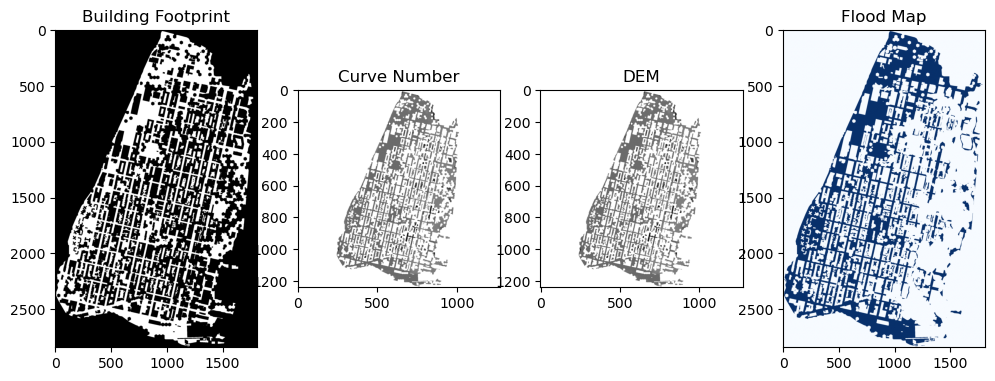

In [8]:
# Visualize a sample in the Dataset 
sample = dataset[3]
plt.figure(figsize=(12, 5))
plt.subplot(1, 4, 1)
plt.imshow(sample["buildings"][0], cmap="gray")
plt.title("Building Footprint")
plt.subplot(1, 4, 2)
plt.imshow(sample["curve"][0], cmap="gray")
plt.title("Curve Number")
plt.subplot(1, 4, 3)
plt.imshow(sample["DEM"][0], cmap="gray")
plt.title("DEM")
plt.subplot(1, 4, 4)
plt.imshow(sample["flood"][0], cmap="Blues")
plt.title("Flood Map")
plt.show()


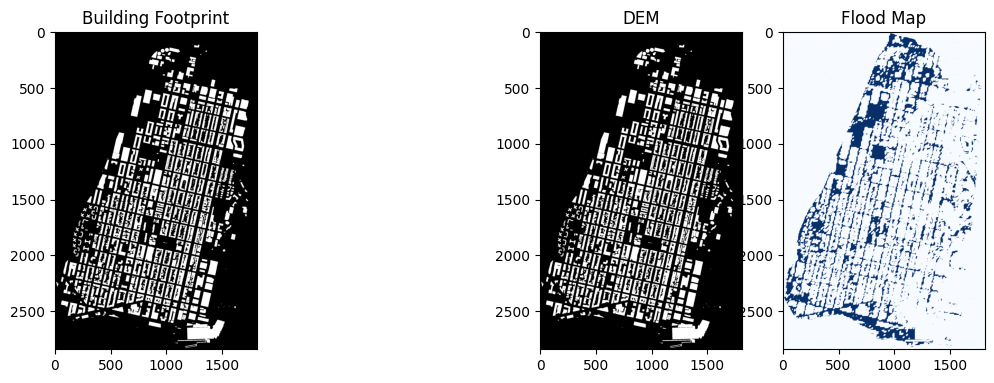

In [21]:
# Visualize a sample in the Dataset 
sample = dataset[5]
plt.figure(figsize=(12, 5))
plt.subplot(1, 4, 1)
plt.imshow(sample["buildings"][0], cmap="gray")
plt.title("Building Footprint")
plt.subplot(1, 4, 3)
plt.imshow(sample["DEM"][0], cmap="gray")
plt.title("DEM")
plt.subplot(1, 4, 4)
plt.imshow(sample["flood"][0], cmap="Blues")
plt.title("Flood Map")
plt.show()


In [11]:
class FloodPredictor(nn.Module):
    def __init__(self, seq_len=24, hidden_dim=64):
        super(FloodPredictor, self).__init__()

        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_dim, batch_first=True)
        self.duration_fc = nn.Linear(1, hidden_dim)

        self.fusion_fc = nn.Linear(hidden_dim * 2, 128 * 128 * 128)

        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, rainfall, duration, target_H, target_W):
        B = rainfall.size(0)

        lstm_out, _ = self.lstm(rainfall)
        rainfall_feat = lstm_out[:, -1, :]

        duration_feat = F.relu(self.duration_fc(duration))
        fused = torch.cat([rainfall_feat, duration_feat], dim=1)

        flat = self.fusion_fc(fused)  # [B, 128*8*8]
        feat = flat.view(B, 128, 128, 128)  

        decoded = self.decoder(feat)  # [B, 1, 8, 8]
        flood_pred = F.interpolate(decoded, size=(target_H, target_W), mode="bilinear", align_corners=False)
        return flood_pred.squeeze(1)  # [B, H, W]


In [31]:
import torch
import torch.nn.functional as F

def masked_bce_loss(pred, target, mask, eps=1e-8):
    """
    pred: (B, H, W) – model output (after sigmoid if using BCELoss, or raw logits if using BCEWithLogitsLoss)
    target: (B, H, W) – ground truth flood map in [0, 1]
    mask: (B, H, W) – binary mask where 1 = building (ignore), 0 = valid flood area (include)
    """

    # Invert the mask so that 1 = valid training area, 0 = ignored
    mask = 1 - mask.float()

    # Safety check
    assert mask.max() <= 1 and mask.min() >= 0, "Mask must be binary (0 or 1)"

    # Compute BCE loss without reduction
    loss = F.binary_cross_entropy(pred, target, reduction='none')  # shape: (B, H, W)

    # Apply the mask: zero out loss for ignored areas
    masked_loss = loss * mask

    # Normalize by number of valid pixels
    norm = mask.sum() + eps  # eps avoids divide-by-zero
    return masked_loss.sum() / norm


In [12]:
# Setup
model = FloodPredictor()
model = nn.DataParallel(model)
model = model.to(device)
#model = FloodPredictor().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()
num_epochs = 10

# Dataloader
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Creating mask for loss function
#mask = test_dataset[0]["buildings"]

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        rain = batch['rainfall'].to(device)
        dur = batch['duration'].to(device)
        flood = batch['flood'].to(device).squeeze(1).float()

        pred = model(rain, dur, 2842, 1812)
        #pred = model(rain, dur)
        #loss = masked_bce_loss(pred, flood, mask)
        loss = criterion(pred, flood)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.2956
Epoch 2, Loss: 0.1789
Epoch 3, Loss: 0.1653
Epoch 4, Loss: 0.1616
Epoch 5, Loss: 0.1612
Epoch 6, Loss: 0.1555
Epoch 7, Loss: 0.1536
Epoch 8, Loss: 0.1526
Epoch 9, Loss: 0.1487
Epoch 10, Loss: 0.1483


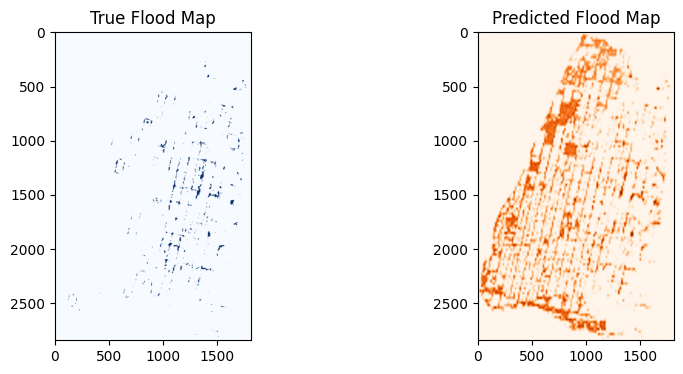

In [33]:
# Visualize a sample prediction for test dataset
model.eval()
sample = test_dataset[2]
with torch.no_grad():
    pred = model(sample["rainfall"].unsqueeze(0).to(device), sample["duration"].unsqueeze(0).to(device), 2842, 1812)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample["flood"].squeeze().cpu().numpy(), cmap="Blues")
plt.title("True Flood Map")
plt.subplot(1, 2, 2)
plt.imshow(pred.squeeze().cpu().numpy(), cmap="Oranges")
plt.title("Predicted Flood Map")
plt.show()


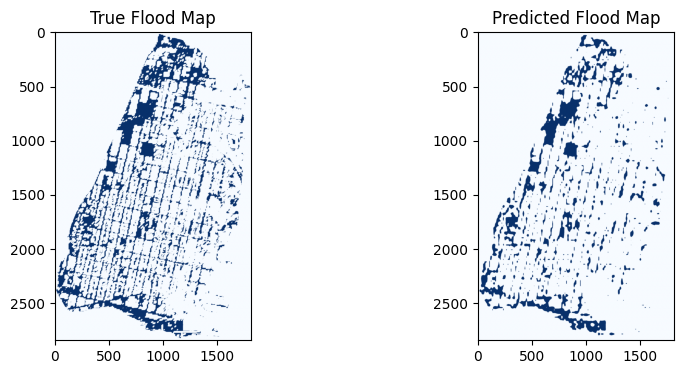

In [26]:
# Visualize a sample prediction for test dataset
model.eval()
sample = test_dataset[1]
with torch.no_grad():
    pred = model(sample["rainfall"].unsqueeze(0).to(device), sample["duration"].unsqueeze(0).to(device), 2842, 1812)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample["flood"].squeeze().cpu().numpy(), cmap="Blues")
plt.title("True Flood Map")
plt.subplot(1, 2, 2)
predicted_flood_map = (pred.squeeze().cpu().numpy() > 0.4).astype(np.float32)
#plt.imshow(predicted_flood_map, cmap="Oranges")
plt.imshow(predicted_flood_map, cmap="Blues")
plt.title("Predicted Flood Map")
plt.show()

In [14]:
def evaluate_model(model, dataset, threshold=0.4):
    
    '''
    calculate flood map for test dataset and copute confusion matrix, accuracy, precision, and recall.
    
    '''
    
    model.eval()
    y_true_all = []
    y_pred_all = []

    with torch.no_grad():
        for i in range(len(dataset)):
            sample = dataset[i]
            rain = sample["rainfall"].unsqueeze(0).to(device)
            dur = sample["duration"].unsqueeze(0).to(device)

            pred = model(rain, dur, 2842, 1812)
            pred_binary = (pred.squeeze().cpu().numpy() > threshold).astype(int)
            true_binary = sample["flood"].numpy().astype(int)

            y_pred_all.extend(pred_binary.flatten())
            y_true_all.extend(true_binary.flatten())

    # Convert to numpy arrays
    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)

    # Confusion matrix
    cm = confusion_matrix(y_true_all, y_pred_all)
    acc = accuracy_score(y_true_all, y_pred_all)
    prec = precision_score(y_true_all, y_pred_all)
    rec = recall_score(y_true_all, y_pred_all)

    return cm, acc, prec, rec, y_true_all, y_pred_all


In [15]:
def plot_confusion_matrix(y_true, y_pred, labels=["Not Flooded", "Flooded"], title="Confusion Matrix"):
    '''
    Visualize the cofusion matrix
    
    '''
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(3, 3))
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_color("black")
        
    plt.tight_layout()
    plt.show()


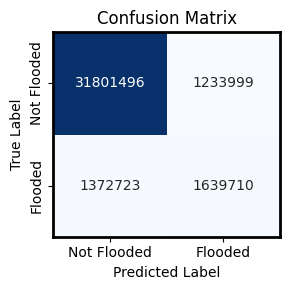

Confusion Matrix:
 [[31801496  1233999]
 [ 1372723  1639710]]
Accuracy:  0.928
Precision: 0.571
Recall:    0.544


In [16]:
cm, acc, prec, rec, y_true_all, y_pred_all = evaluate_model(model, test_dataset)
plot_confusion_matrix(y_true_all, y_pred_all)
print("Confusion Matrix:\n", cm)
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")